In [1]:
import matplotlib.pyplot as plt
import cv2
from matplotlib.colors import ListedColormap
from matplotlib.patches import Rectangle
import numpy as np
import torch
import torchvision


In [2]:
import torch
import torchvision
torchvision.ops.generalized_box_iou_loss(torch.Tensor([0.1, 0.1, 0.3, 0.3]), torch.Tensor([0.5, 0.5, 0.99, 0.99]), reduction='mean')

tensor(1.6464)

In [3]:

mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
def input_transform(image):
    print(image.shape)
    image = image.astype(np.float32)[:, :, ::-1]
    image = cv2.resize(image, (512, 256))
    image = image / 255.0
    image -= mean
    image /= std
    return image

def load_pretrained(model, pretrained):
    pretrained_dict = torch.load(pretrained, map_location='cpu')
    if 'state_dict' in pretrained_dict:
        pretrained_dict = pretrained_dict['state_dict']
    model_dict = model.state_dict()
    pretrained_dict = {k[6:]: v for k, v in pretrained_dict.items() if (k[6:] in model_dict and v.shape == model_dict[k[6:]].shape)}
    msg = 'Loaded {} parameters!'.format(len(pretrained_dict))
    print('Attention!!!')
    print(msg)
    print('Over!!!')
    model_dict.update(pretrained_dict)
    model.load_state_dict(model_dict, strict = False)
    
    return model

In [4]:
import models
model = models.pidnet.PIDNet(m=2, n=3, num_classes=19, planes=32, ppm_planes=96, head_planes=128, augment=False)
model = load_pretrained(model, 'output/cityscapes/pidnet_small_cityscapes/model/best+33.pt').cuda()
model.eval()

Attention!!!
Loaded 678 parameters!
Over!!!


PIDNet(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
  )
  (relu): ReLU(inplace=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1,

In [8]:

import glob
images_list = glob.glob('samples/' + '*'+'.png')
print(len(images_list))
sv_path = 'samples/'+'instance/'

2


In [45]:
import os
import torch.nn.functional as F
from PIL import Image
color_map = [(128, 64,128),
             (244, 35,232),
             ( 70, 70, 70),
             (102,102,156),
             (190,153,153),
             (153,153,153),
             (250,170, 30),
             (220,220,  0),
             (107,142, 35),
             (152,251,152),
             ( 70,130,180),
             (220, 20, 60),
             (255,  0,  0),
             (  0,  0,142),
             (  0,  0, 70),
             (  0, 60,100),
             (  0, 80,100),
             (  0,  0,230),
             (119, 11, 32)]
with torch.no_grad():
    for img_path in images_list:
        img_name = img_path.split("/")[-1]
        img = cv2.imread(os.path.join('samples/', img_name),
                            cv2.IMREAD_COLOR)
        sv_img = np.zeros_like(img).astype(np.uint8)
        img = input_transform(img)
        img = img.transpose((2, 0, 1)).copy()
        img = torch.from_numpy(img).unsqueeze(0).cuda()
        pred = model(img)
        # break
        print(pred.shape)
        break
        # bbox = pred[0]
        # pred = pred[-1]
        # print(len(pred))
        # print(pred.shape)
        # pred = F.interpolate(pred, size=img.size()[-2:], 
        #                         mode='bilinear', align_corners=True)
        # print(pred.shape)
        # pred = torch.argmax(pred, dim=1).squeeze(0).cpu().numpy()
        # print(pred.shape)
        # for i, color in enumerate(color_map):
        #     for j in range(3):
        #         sv_img[:,:,j][pred==i] = color_map[i][j]
        # sv_img = Image.fromarray(sv_img)
        
        # if not os.path.exists(sv_path):
        #     os.mkdir(sv_path)
        # sv_img.save(sv_path+img_name)

(1024, 2048, 3)
torch.Size([1, 19, 4, 2])


In [46]:
x = (pred.cpu()+1)*np.array([516, 1024])

In [47]:
for img_path in images_list[:-1]:
    img_name = img_path.split("/")[-1]
    img = cv2.imread(os.path.join('samples/', img_name),
                        cv2.IMREAD_COLOR)

In [48]:
y = x[:, 0][0]

In [49]:
y

tensor([[ 516.0008, 1024.0293],
        [1011.7527, 2039.9602],
        [1011.7645, 2039.9841],
        [1011.7628, 2039.9807]], dtype=torch.float64)

In [29]:
y[:, 1]

tensor([1024.0450, 2039.9226, 2039.9836, 2039.9746], dtype=torch.float64)

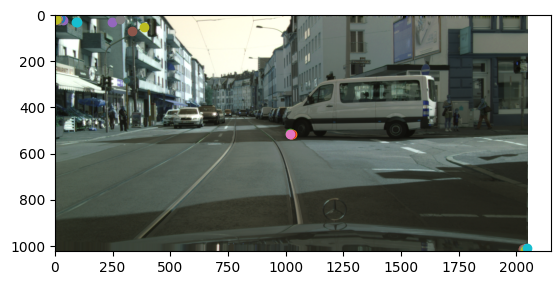

In [54]:
plt.imshow(img)
for i in range(19):
    y = x[:, i][0]
    plt.scatter(y[:, 1], y[:, 0])

In [18]:
from torch import nn
deconv = nn.Sequential(
            nn.BatchNorm2d(128),
            nn.ConvTranspose2d(128,256,3,2,1,1),
            nn.ReLU(True),
            nn.BatchNorm2d(256),
            nn.ConvTranspose2d(256,128,3,2,1,1),
            nn.ReLU(True),
            nn.BatchNorm2d(128),
            nn.ConvTranspose2d(128,19,3,2,1,1),
            nn.ReLU(True),
        )

In [10]:
x = torch.randn([1, 19, 4, 2])
x

tensor([[[[ 0.7317,  0.3720],
          [-1.0555, -0.4898],
          [ 0.1965, -0.3725],
          [ 0.2055,  0.9074]],

         [[ 0.9650,  1.2262],
          [ 0.1838,  2.5436],
          [-1.0578, -0.5844],
          [-0.0549, -0.7298]],

         [[ 1.1222,  1.2354],
          [-0.0809,  0.8186],
          [ 3.4279, -0.2592],
          [ 1.7201, -0.8289]],

         [[ 1.0846,  1.2346],
          [ 1.5861, -0.3214],
          [-1.1929, -1.6264],
          [-1.5162, -0.8638]],

         [[-1.2451, -1.1031],
          [-0.7434, -1.8724],
          [-0.7773,  0.8107],
          [ 0.9469,  1.3868]],

         [[ 0.1541, -0.3903],
          [ 0.3798, -0.1848],
          [-2.2140, -2.0012],
          [ 1.8252, -0.3189]],

         [[ 0.2847,  0.8324],
          [ 1.1881, -0.0873],
          [ 0.3020,  0.3671],
          [-0.7767,  0.2124]],

         [[ 1.4462, -0.5867],
          [ 0.9242, -0.8881],
          [ 1.0087, -1.1906],
          [-1.6056,  2.2287]],

         [[ 1.7603, -0.0

In [14]:
torch.cat([x[:, :, 0, :], x[:, :, 2, :]], dim=2)

RuntimeError: The size of tensor a (4) must match the size of tensor b (2) at non-singleton dimension 2

In [12]:
x*torch.FloatTensor([1,0])

tensor([[[[ 0.7317,  0.0000],
          [-1.0555, -0.0000],
          [ 0.1965, -0.0000],
          [ 0.2055,  0.0000]],

         [[ 0.9650,  0.0000],
          [ 0.1838,  0.0000],
          [-1.0578, -0.0000],
          [-0.0549, -0.0000]],

         [[ 1.1222,  0.0000],
          [-0.0809,  0.0000],
          [ 3.4279, -0.0000],
          [ 1.7201, -0.0000]],

         [[ 1.0846,  0.0000],
          [ 1.5861, -0.0000],
          [-1.1929, -0.0000],
          [-1.5162, -0.0000]],

         [[-1.2451, -0.0000],
          [-0.7434, -0.0000],
          [-0.7773,  0.0000],
          [ 0.9469,  0.0000]],

         [[ 0.1541, -0.0000],
          [ 0.3798, -0.0000],
          [-2.2140, -0.0000],
          [ 1.8252, -0.0000]],

         [[ 0.2847,  0.0000],
          [ 1.1881, -0.0000],
          [ 0.3020,  0.0000],
          [-0.7767,  0.0000]],

         [[ 1.4462, -0.0000],
          [ 0.9242, -0.0000],
          [ 1.0087, -0.0000],
          [-1.6056,  0.0000]],

         [[ 1.7603, -0.0

In [46]:
def find_bounding_box(mask, intensity, confidence_score=1):
    rows, cols = np.where(mask == intensity)
    if len(rows) == 0 or len(cols) == 0:
        return None
    min_row, max_row = min(rows), max(rows)
    min_col, max_col = min(cols), max(cols)
    return min_row/mask.shape[0], min_col/mask.shape[1], max_row/mask.shape[0], max_col/mask.shape[1], confidence_score

def get_bb_box(path):
    instance_image = cv2.imread(path, cv2.IMREAD_ANYDEPTH)
    mask = np.logical_and(instance_image >= 26000, instance_image < 27000)
    instance_image = np.where(mask, instance_image, -1)
    unique_intensities, counts = np.unique(instance_image, return_counts=True)
    n = 20
    top_n_indices = np.flip(np.argsort(counts)[-n:])
    top_n_intensities = unique_intensities[top_n_indices]
    if -1 in top_n_intensities:
        top_n_intensities = top_n_intensities[top_n_intensities != -1]
    else:
        top_n_intensities = top_n_intensities[:-1]
    mapping = {intensity: rank for rank, intensity in enumerate(top_n_intensities)}
    mapped_image = np.vectorize(lambda x: mapping.get(x, -1))(instance_image)

    bounding_boxes = []
    for intensity in np.arange(0, 19):
        if intensity == -1:
            continue
        bbox = find_bounding_box(mapped_image, intensity)
        if bbox:
            bounding_boxes.append(bbox)
        else:
            bounding_boxes.append((0, 0, 0, 0, 0))
    return np.array(bounding_boxes)


[-1]
[]
[-1] [2304000]


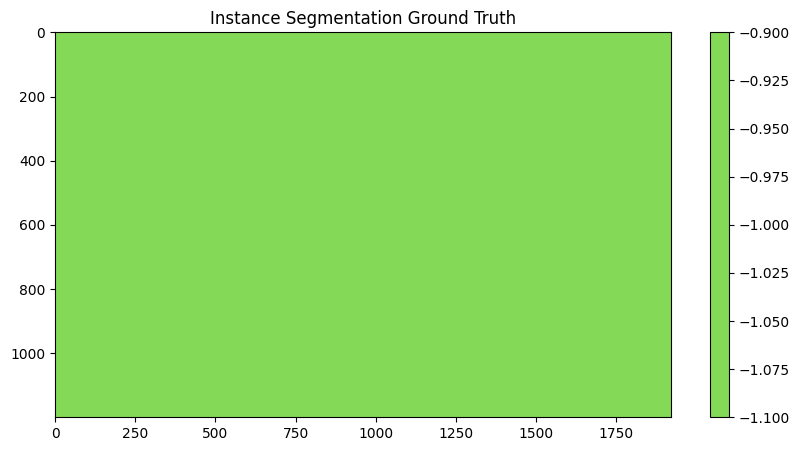

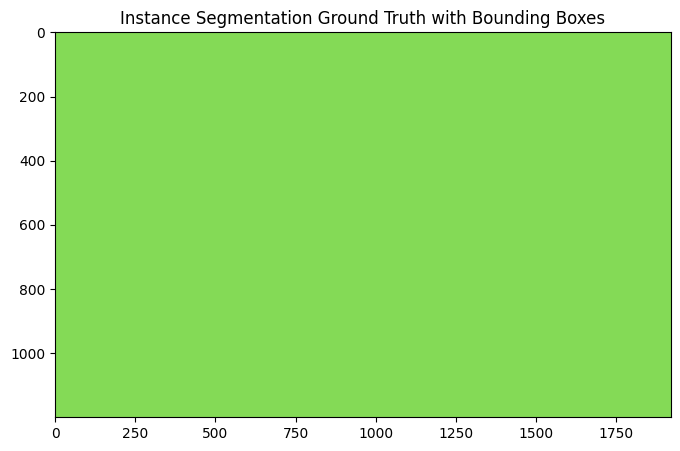

In [55]:
path = '/home/moonlab/Documents/PIDNet/data/00000/pylon_camera_node_label_id/frame000000-1581624652_750.png'
instance_image = cv2.imread(path, cv2.IMREAD_ANYDEPTH)
mask = np.logical_and(instance_image >= 26000, instance_image < 27000)
instance_image = np.where(mask, instance_image, -1)
unique_intensities, counts = np.unique(instance_image, return_counts=True)
n = 20
top_n_indices = np.flip(np.argsort(counts)[-n:])
top_n_intensities = unique_intensities[top_n_indices]
if -1 in top_n_intensities:
    top_n_intensities = top_n_intensities[top_n_intensities != -1]
else:
    top_n_intensities = top_n_intensities[:-1]
mapping = {intensity: rank for rank, intensity in enumerate(top_n_intensities)}
mapped_image = np.vectorize(lambda x: mapping.get(x, -1))(instance_image)
print(np.unique(mapped_image))
print(top_n_intensities)
print(unique_intensities, counts)


# Define colormap for visualization
cmap = ListedColormap(np.random.rand(len(np.unique(mapped_image.flatten())), 3))

# instance_image_masked = instance_image_masked % 26000
# Visualize the instance segmentation ground truth image
plt.figure(figsize=(10, 5))
plt.imshow(mapped_image, cmap=cmap, interpolation='nearest')
plt.colorbar()
plt.title('Instance Segmentation Ground Truth')
plt.show()


# Function to find bounding box coordinates
def find_bounding_box(mask, intensity):
    rows, cols = np.where(mask == intensity)
    if len(rows) == 0 or len(cols) == 0:
        return None
    min_row, max_row = min(rows), max(rows)
    min_col, max_col = min(cols), max(cols)
    return min_row, min_col, max_row, max_col
bounding_boxes = {}

# Find bounding boxes for each unique intensity
for intensity in np.unique(mapped_image):
    if intensity == -1:
        continue
    bbox = find_bounding_box(mapped_image, intensity)
    if bbox:
        bounding_boxes[intensity] = bbox

# Print bounding box coordinates
for intensity, bbox in bounding_boxes.items():
    print(f"Intensity {intensity}: Bounding box {bbox}")

# Plot bounding boxes
plt.figure(figsize=(10, 5))
plt.imshow(mapped_image, cmap=cmap, interpolation='nearest')

for intensity, bbox in bounding_boxes.items():
    min_row, min_col, max_row, max_col = bbox
    rect = Rectangle((min_col, min_row), max_col - min_col, max_row - min_row,
                     linewidth=2, edgecolor='r', facecolor='none')
    plt.gca().add_patch(rect)

plt.title('Instance Segmentation Ground Truth with Bounding Boxes')
plt.show()


In [56]:
path = '/home/moonlab/Documents/PIDNet/data/00000/pylon_camera_node_label_id/frame000000-1581624652_750.png'
instance_image = cv2.imread(path, cv2.IMREAD_ANYDEPTH)

In [57]:
np.unique(instance_image)

array([ 3,  4,  7,  8,  9, 18, 19, 31, 33], dtype=uint8)

In [61]:
img_list = [line.strip().split() for line in open('data/list/cityscapes/train_inst.lst')]
def get_bb_box(path):
    path = path.replace("label", "instance")
    print(path)
    instance_image = cv2.imread(path, cv2.IMREAD_ANYDEPTH)
    print(instance_image.shape)
    mask = np.logical_and(instance_image >= 26000, instance_image < 27000)
    instance_image = np.where(mask, instance_image, -1)
    unique_intensities, counts = np.unique(instance_image, return_counts=True)
    n = 20
    top_n_indices = np.flip(np.argsort(counts)[-n:])
    top_n_intensities = unique_intensities[top_n_indices]
    if -1 in top_n_intensities:
        top_n_intensities = top_n_intensities[top_n_intensities != -1]
    else:
        top_n_intensities = top_n_intensities[:-1]
    mapping = {intensity: rank for rank, intensity in enumerate(top_n_intensities)}
    mapped_image = np.vectorize(lambda x: mapping.get(x, -1))(instance_image)

    bounding_boxes = []
    for intensity in np.arange(0, 19):
        if intensity == -1:
            continue
        bbox = find_bounding_box(mapped_image, intensity)
        print(bbox)
        if bbox:
            bounding_boxes.append(bbox)
            print(1)
        else:
            bounding_boxes.append([0, 0, 0, 0, 0])
            print(2)
        print(bounding_boxes)
    return np.array(bounding_boxes)
for path in img_list:
    print(get_bb_box('/home/moonlab/Documents/dse316/PIDNet/data/cityscapes/'+path[1].replace("label", "instance")))

/home/moonlab/Documents/dse316/PIDNet/data/cityscapes/gtFine/train/aachen/aachen_000000_000019_gtFine_instanceIds.png
(1024, 2048)
(420, 609, 531, 807)
1
[(420, 609, 531, 807)]
(429, 145, 501, 304)
1
[(420, 609, 531, 807), (429, 145, 501, 304)]
(456, 1479, 513, 1634)
1
[(420, 609, 531, 807), (429, 145, 501, 304), (456, 1479, 513, 1634)]
(450, 1721, 508, 1850)
1
[(420, 609, 531, 807), (429, 145, 501, 304), (456, 1479, 513, 1634), (450, 1721, 508, 1850)]
(488, 1966, 521, 2042)
1
[(420, 609, 531, 807), (429, 145, 501, 304), (456, 1479, 513, 1634), (450, 1721, 508, 1850), (488, 1966, 521, 2042)]
(446, 1512, 498, 1660)
1
[(420, 609, 531, 807), (429, 145, 501, 304), (456, 1479, 513, 1634), (450, 1721, 508, 1850), (488, 1966, 521, 2042), (446, 1512, 498, 1660)]
(486, 1876, 512, 1955)
1
[(420, 609, 531, 807), (429, 145, 501, 304), (456, 1479, 513, 1634), (450, 1721, 508, 1850), (488, 1966, 521, 2042), (446, 1512, 498, 1660), (486, 1876, 512, 1955)]
(482, 1876, 486, 1921)
1
[(420, 609, 531, 807

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (19,) + inhomogeneous part.

In [5]:
path = '/home/moonlab/Documents/dse316/PIDNet/data/cityscapes/gtFine/train/aachen/aachen_000003_000019_gtFine_instanceIds.png'
instance_image = cv2.imread(path, cv2.IMREAD_ANYDEPTH)
mask = np.logical_and(instance_image >= 26000, instance_image < 27000)
instance_image = np.where(mask, instance_image, -1)
unique_intensities, counts = np.unique(instance_image, return_counts=True)
n = 19
top_n_indices = np.argsort(counts)[-n-1:-1]
top_n_intensities = unique_intensities[top_n_indices]
mapping = {intensity: rank for rank, intensity in enumerate(top_n_intensities)}
mapped_image = np.vectorize(lambda x: mapping.get(x, -1))(instance_image)
print(np.unique(mapped_image))

[-1  0  1  2  3  4  5  6  7  8  9]


In [10]:
x = np.random.rand(len(np.unique(mapped_image.flatten())), 3)

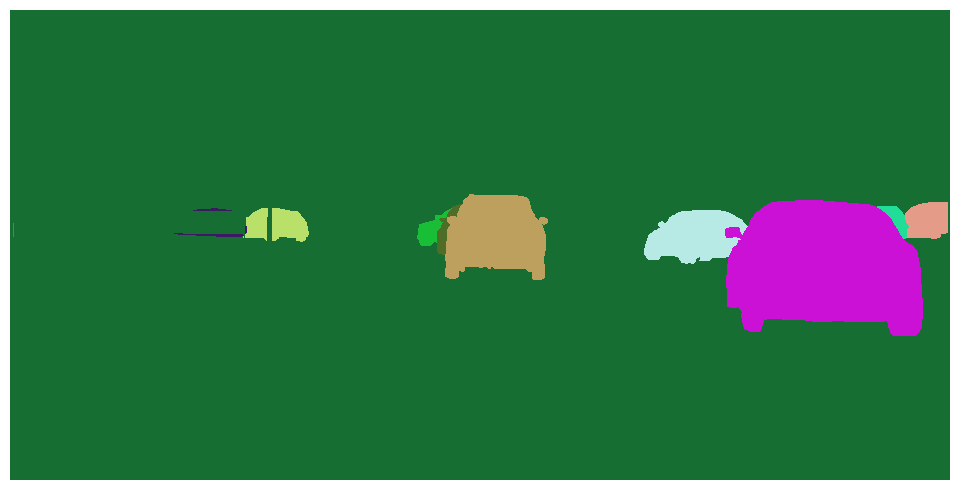

Intensity 0: Bounding box (460, 6, 495, 8)
Intensity 1: Bounding box (431, 358, 494, 516)
Intensity 2: Bounding box (422, 930, 533, 984)
Intensity 3: Bounding box (427, 1888, 499, 1958)
Intensity 4: Bounding box (432, 887, 514, 961)
Intensity 5: Bounding box (418, 1949, 497, 2042)
Intensity 6: Bounding box (432, 507, 504, 650)
Intensity 7: Bounding box (435, 1382, 552, 1606)
Intensity 8: Bounding box (400, 947, 588, 1172)
Intensity 9: Bounding box (414, 1557, 710, 1989)


In [11]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# Define colormap for visualization
cmap = ListedColormap(x)

# instance_image_masked = instance_image_masked % 26000
# Visualize the instance segmentation ground truth image
plt.figure(figsize=(10, 5))
plt.imshow(mapped_image, cmap=cmap, interpolation='nearest')
# plt.colorbar()
plt.axis('Off')
plt.tight_layout()
# plt.title('Instance Segmentation Ground Truth')
plt.show()


# Function to find bounding box coordinates
def find_bounding_box(mask, intensity):
    rows, cols = np.where(mask == intensity)
    if len(rows) == 0 or len(cols) == 0:
        return None
    min_row, max_row = min(rows), max(rows)
    min_col, max_col = min(cols), max(cols)
    return min_row, min_col, max_row, max_col
bounding_boxes = {}

# Find bounding boxes for each unique intensity
for intensity in np.unique(mapped_image):
    if intensity == -1:
        continue
    bbox = find_bounding_box(mapped_image, intensity)
    if bbox:
        bounding_boxes[intensity] = bbox

# Print bounding box coordinates
for intensity, bbox in bounding_boxes.items():
    print(f"Intensity {intensity}: Bounding box {bbox}")

In [23]:
# Get unique pixel intensities
unique_intensities = np.unique(instance_image_masked)

# Function to find bounding box coordinates
def find_bounding_box(mask, intensity):
    rows, cols = np.where(mask == intensity)
    if len(rows) == 0 or len(cols) == 0:
        return None
    min_row, max_row = min(rows), max(rows)
    min_col, max_col = min(cols), max(cols)
    return min_row, min_col, max_row, max_col

# Dictionary to store bounding box coordinates for each intensity
bounding_boxes = {}

# Find bounding boxes for each unique intensity
for intensity in unique_intensities:
    bbox = find_bounding_box(instance_image_masked, intensity)
    if bbox:
        bounding_boxes[intensity] = bbox

# Print bounding box coordinates
for intensity, bbox in bounding_boxes.items():
    print(f"Intensity {intensity}: Bounding box {bbox}")

NameError: name 'instance_image_masked' is not defined

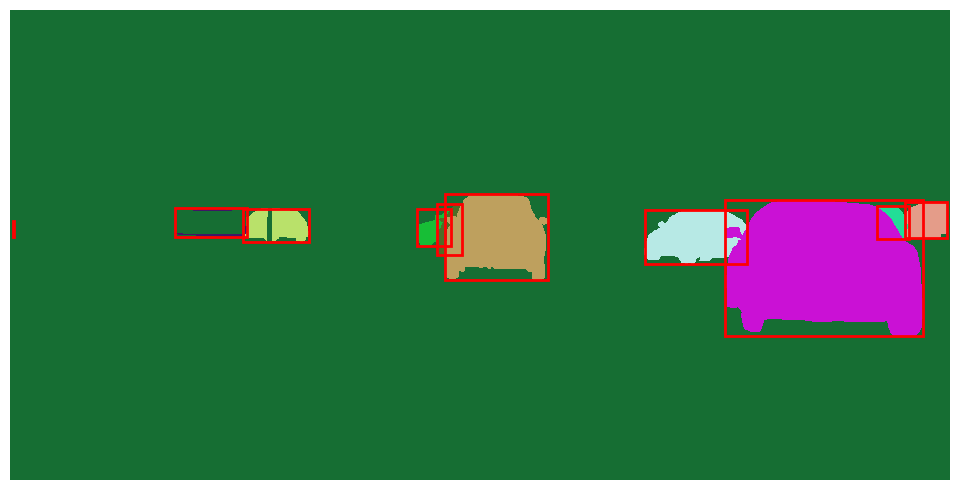

In [13]:
# Plot bounding boxes
plt.figure(figsize=(10, 5))
plt.imshow(mapped_image, cmap=cmap, interpolation='nearest')
from matplotlib.patches import Rectangle
for intensity, bbox in bounding_boxes.items():
    min_row, min_col, max_row, max_col = bbox
    rect = Rectangle((min_col, min_row), max_col - min_col, max_row - min_row,
                     linewidth=2, edgecolor='r', facecolor='none')
    plt.gca().add_patch(rect)
plt.axis('Off')
plt.tight_layout()
# plt.title('Instance Segmentation Ground Truth with Bounding Boxes')
plt.show()

In [86]:
img_list = [line.strip().split() for line in open('data/'+'list/cityscapes/train_inst.lst')]

In [87]:
files = []
import os
for item in img_list:
    image_path, label_path = item
    name = os.path.splitext(os.path.basename(label_path))[0]
    files.append({
        "img": image_path,
        "label": label_path,
        "name": name
    })

In [58]:
import cv2
labels = []
LEN = []
for file in files:
    instance_image = cv2.imread('data/cityscapes/'+file["label"], cv2.IMREAD_ANYDEPTH)
    mask = np.logical_and(instance_image >= 26000, instance_image < 27000)

    # Apply the mask to keep instances in the range 26000 to 26999
    instance_image_masked = np.where(mask, instance_image, -1)
    np.unique(instance_image_masked.flatten())
    LEN.append(len(np.unique(instance_image_masked.flatten()))-1)
    if LEN[-1] == 34:
        instance_image_masked = instance_image_masked % 26000
        print(file["label"])
        # Get unique pixel intensities
        # Calculate unique pixel counts for each intensity value
        unique_intensities, counts = np.unique(instance_image_masked, return_counts=True)

        # Get the top n unique intensities with highest counts until the 19th tank
        n = 19
        top_n_indices = np.argsort(counts)[-n-1:-1]
        top_n_intensities = unique_intensities[top_n_indices]
        # unique_intensities = np.unique(instance_image_masked)

        # Function to find bounding box coordinates
        def find_bounding_box(mask, intensity):
            rows, cols = np.where(mask == intensity)
            if len(rows) == 0 or len(cols) == 0:
                return None
            min_row, max_row = min(rows), max(rows)
            min_col, max_col = min(cols), max(cols)
            return min_row, min_col, max_row, max_col

        # Dictionary to store bounding box coordinates for each intensity
        bounding_boxes = {}

        # Find bounding boxes for each unique intensity
        for intensity in top_n_intensities:
            bbox = find_bounding_box(instance_image_masked, intensity)
            if bbox:
                bounding_boxes[intensity] = bbox

        # Print bounding box coordinates
        for intensity, bbox in bounding_boxes.items():
            print(f"Intensity {intensity}: Bounding box {bbox}")
        # Plot bounding boxes
        plt.figure(figsize=(10, 5))
        plt.imshow(instance_image_masked, cmap=cmap, interpolation='nearest')
        from matplotlib.patches import Rectangle
        for intensity, bbox in bounding_boxes.items():
            min_row, min_col, max_row, max_col = bbox
            rect = Rectangle((min_col, min_row), max_col - min_col, max_row - min_row,
                            linewidth=2, edgecolor='r', facecolor='none')
            plt.gca().add_patch(rect)

        plt.title('Instance Segmentation Ground Truth with Bounding Boxes')
        plt.show()
        break


KeyboardInterrupt: 

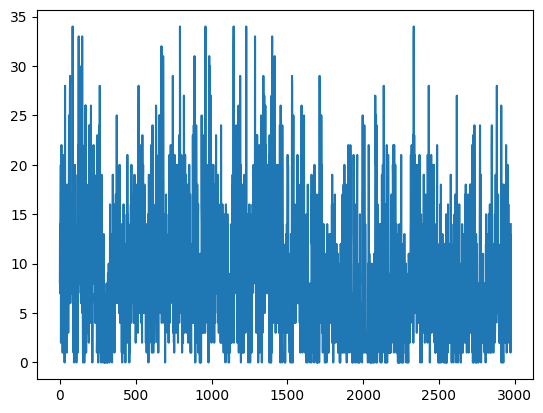

In [36]:
plt.plot(LEN)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


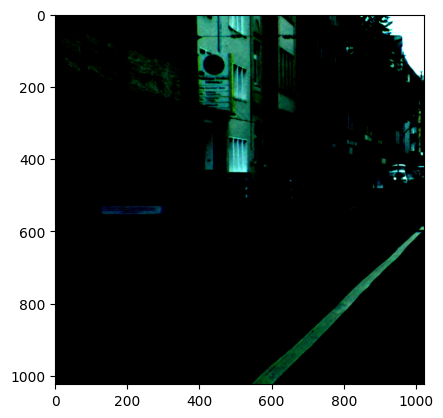

In [44]:
x = np.load('image.npy')
plt.imshow(x)

[  0   1   2   4   5   6   7  11  13  17  18 255]


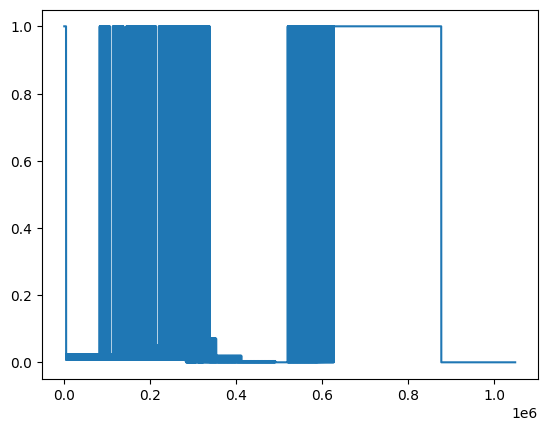

In [73]:
x = np.load('label.npy')
print(np.unique(x))
plt.plot(x.flatten()/255)

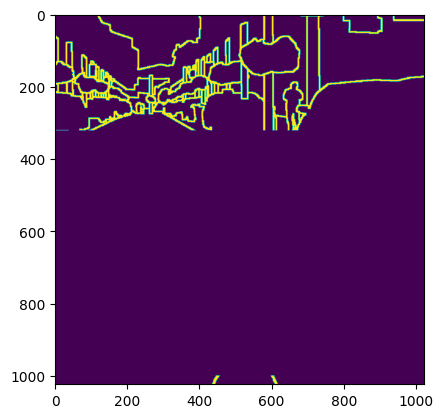

In [40]:
x = np.load('edge.npy')
plt.imshow(x)

In [16]:
path = '/data2/dse316/grp_037/PIDNet/data/cityscapes/gtFine/train/bremen/bremen_000003_000019_gtFine_labelIds.png'
image = plt.imread(path)

In [1]:
import os
import PIL
from PIL import Image
import numpy as np
def boundary(raw_input, save_path, save_name):
    """
    calculate boundary mask & save
    :param raw_input: *instanceIds image
    :param save_path: city name
    :param save_name: boundary mask name
    :return:
    """
    # process instance mask
    instance_mask = Image.open(raw_input)
    width = instance_mask.size[0]
    height = instance_mask.size[1]
    mask_array = np.array(instance_mask)

    # define the boundary mask
    boundary_mask = np.zeros((height, width), dtype=np.uint8)  # 0-255

    # perform boundary calculate: the center pixel_id is differ from the 4-nearest pixels_id
    for i in range(1, height-1):
        for j in range(1, width-1):
            if mask_array[i, j] != mask_array[i - 1, j] \
                    or mask_array[i, j] != mask_array[i + 1, j] \
                    or mask_array[i, j] != mask_array[i, j - 1] \
                    or mask_array[i, j] != mask_array[i, j + 1]:
                boundary_mask[i, j] = 255
    boundary_image = Image.fromarray(np.uint8(boundary_mask))
    # boundary_image.show()
    boundary_image.save(os.path.join(raw_input, save_path, save_name))

In [8]:
boundary('/data2/dse316/grp_037/PIDNet/data/cityscapes/gtFine/train/aachen/aachen_000001_000019_gtFine_instanceIds.png', '/data2/dse316/grp_037/PIDNet', 'test.png')

In [20]:
import cv2
inst = cv2.imread('/data2/dse316/grp_037/PIDNet/data/cityscapes/gtFine/train/aachen/aachen_000001_000019_gtFine_labelIds.png', cv2.IMREAD_ANYDEPTH)


In [8]:
np.unique(inst)

array([    0,     1,     3,     4,     5,     6,     7,     8,    11,
          12,    13,    17,    19,    20,    21,    22,    23, 26000,
       26001, 26002, 26003, 26005, 26006, 26007, 26008, 26009, 26010,
       26011, 26012, 26013, 26014], dtype=uint16)

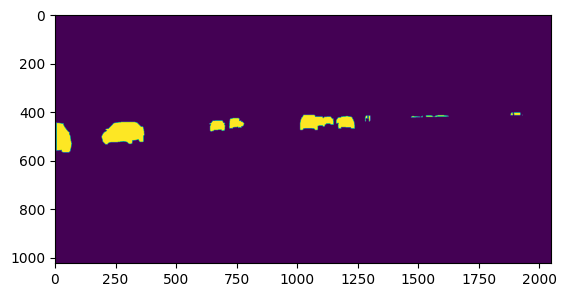

In [4]:
import matplotlib.pyplot as plt
plt.imshow(inst)

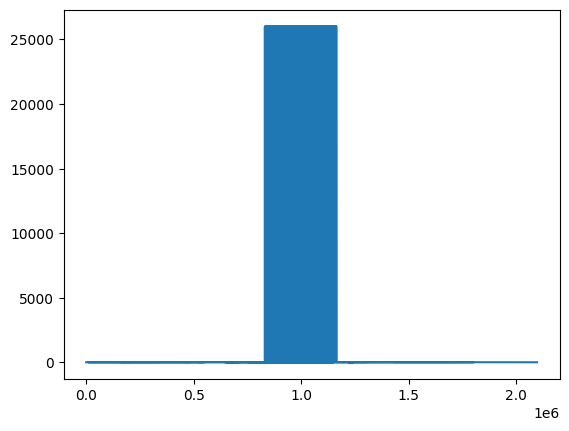

In [5]:
plt.plot(inst.flatten())

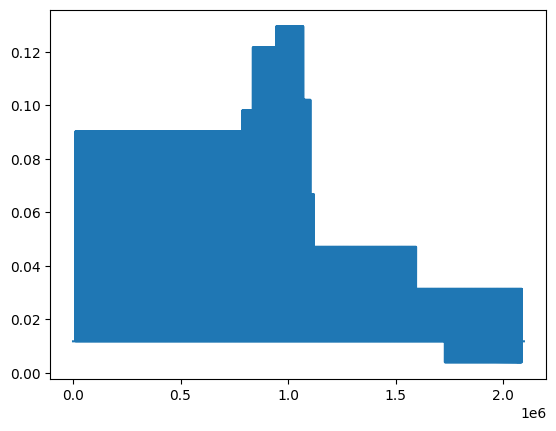

In [20]:
plt.plot(image.flatten())